In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from conrad import *

optkit backend set to cpu64


In [4]:
# dimensions
voxels = 1000
beams = 200

# voxel labels
labels = (np.random.rand(voxels) > 0.2).astype(int)

# dose matrix with target voxels receiving ~3x radiation of non-target voxels
# label 0 = TUMOR, label 1 = OAR
A = np.random.rand(voxels, beams)
FACTOR = 3
for i, label in enumerate(labels):
    if label == 0:
        A[i, :] *= FACTOR
        
# construct case
case = Case()
case.anatomy = Anatomy([Structure(0, 'TUMOR', True), Structure(1, 'OAR', False)])
case.physics = Physics(dose_matrix=A, voxel_labels=labels)


# initialize CasePlotter object
graphics = CasePlotter(case)

In [5]:
# add DVH constraints
case.anatomy['TUMOR'].constraints += D(15) < 1.05 * Gy
case.anatomy['TUMOR'].constraints += D(85) > 0.9 * Gy
case.anatomy['OAR'].constraints += D(50) < 0.4 * Gy

('running solver...',)
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 644354
eps = 1.00e-03, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
Variables n = 2390, constraints m = 4580
Cones:	linear vars: 4580
Setup time: 2.80e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.05e+00  5.19e-01  7.20e-01 -7.24e-01  1.84e+00  1.46e-15  1.16e-02 
   100| 1.27e-03  3.12e-03  5.65e-04 -4.64e-01 -4.65e-01  4.24e-16  3.04e-01 
   140| 9.17e-04  7.31e-04  6.24e-04 -4.64e-01 -4.66e-01  1.26e-15  4.20e-01 
-----------------------------------------------------------

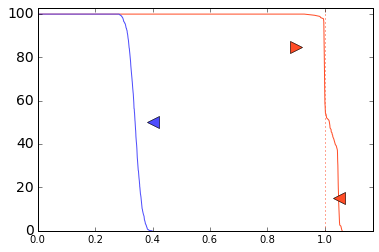

In [6]:
# solve: WITHOUT slack, ONE pass (restricted DVH constraints)
status, run = case.plan(use_slack=False)
print('SOLVER CONVERGED?', status)
graphics.plot(run)

('running solver...',)
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 644354
eps = 1.00e-03, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
Variables n = 2390, constraints m = 4580
Cones:	linear vars: 4580
Setup time: 2.96e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.05e+00  5.19e-01  7.20e-01 -7.24e-01  1.84e+00  1.46e-15  9.33e-03 
   100| 1.27e-03  3.12e-03  5.65e-04 -4.64e-01 -4.65e-01  4.24e-16  2.91e-01 
   140| 9.17e-04  7.31e-04  6.24e-04 -4.64e-01 -4.66e-01  1.26e-15  4.11e-01 
-----------------------------------------------------------

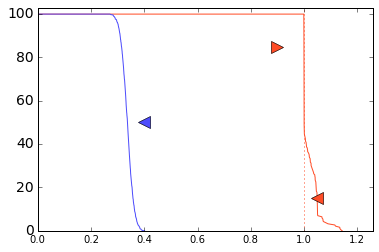

In [7]:
# solve: WITHOUT slack, TWO passes (exact DVH constraints)
status, run = case.plan(use_slack=False, use_2pass=True)
print('SOLVER CONVERGED?', status)
graphics.plot(run, second_pass=True)

In [8]:
# additional DVH constraints makes no-slack problem infeasible
case.anatomy['TUMOR'].constraints += D(99) > 0.99 * Gy
case.anatomy['TUMOR'].constraints += D(1) < 1.01 * Gy

In [9]:
# solving without slacks will result in infeasibility
status, run = case.plan(dvh_slack=False)
print('SOLVER CONVERGED?', status)

('running solver...',)
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 720654
eps = 1.00e-03, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
Variables n = 2766, constraints m = 5332
Cones:	linear vars: 5332
Setup time: 3.16e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.45e+00  4.77e-01  7.33e-01 -8.24e-01  1.92e+00  1.41e-15  1.14e-02 
   100| 4.67e-03  6.86e-03  3.03e-03 -4.58e-01 -4.52e-01  4.37e-16  3.26e-01 
   200| 4.42e-03  1.51e-02  7.84e-03 -4.56e-01 -4.41e-01  5.23e-16  6.45e-01 
   300| 4.91e-03  3.01e-02  1.67e-02 -4.52e-01 -4.20e-01  7

/Users/Baris/Documents/Thesis/modules/conrad/conrad/case.py:205: UserWarning: Problem infeasible as formulated
  warn('Problem infeasible as formulated')


('running solver...',)
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 722220
eps = 1.00e-03, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
Variables n = 2771, constraints m = 5337
Cones:	linear vars: 5337
Setup time: 3.75e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.06e+00  1.92e-01  7.22e-01 -8.10e-01  1.78e+00  1.32e-15  1.78e-02 
   100| 9.29e-04  1.16e-03  1.19e-03 -4.61e-01 -4.63e-01  1.15e-15  5.38e-01 
   140| 6.38e-04  9.81e-04  4.84e-04 -4.61e-01 -4.62e-01  3.80e-16  8.08e-01 
-----------------------------------------------------------

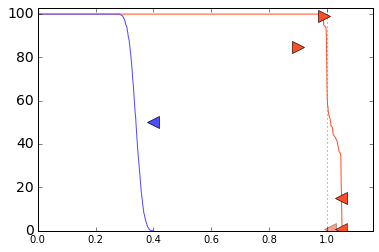

In [10]:
# solve: WITH slack, ONE pass
# (N.B.: use_slack=True by default, so could call w/o use_slack argument)
status, run = case.plan(use_slack=True)
print('SOLVER CONVERGED?', status)
graphics.plot(run)

('running solver...',)
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 722220
eps = 1.00e-03, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
Variables n = 2771, constraints m = 5337
Cones:	linear vars: 5337
Setup time: 2.92e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.06e+00  1.89e-01  7.21e-01 -8.16e-01  1.77e+00  1.33e-15  1.12e-02 
   100| 9.65e-04  1.92e-03  7.94e-04 -4.64e-01 -4.66e-01  7.66e-16  3.45e-01 
   120| 8.74e-04  7.86e-04  7.73e-04 -4.64e-01 -4.66e-01  7.62e-16  4.15e-01 
-----------------------------------------------------------

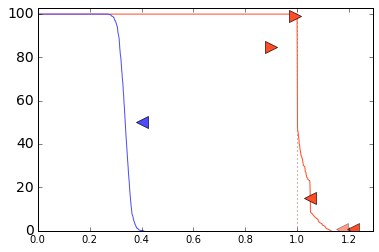

In [11]:
# solve: WITH slack, TWO passes 
status, run = case.plan(use_2pass=True)
print('SOLVER CONVERGED?', status)
graphics.plot(run, second_pass=True)